In [1]:
%load_ext autoreload
%autoreload 2

# set cuda device 0 to visible
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from medvae.utils.factory import download_model_weights, FILE_DICT_ASSOCIATIONS
from omegaconf import OmegaConf
from medvae.models import AutoencoderKL_2D
import torch
from accelerate import Accelerator
from medvae.dataloaders import GenericDataset
from torchvision.transforms import Compose
from medvae.utils.loaders import load_bruno, load_bruno_dicoms
from matplotlib import pyplot as plt
import numpy as np

/home/yurman/miniforge3/envs/longitudinal-diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yurman/miniforge3/envs/longitudinal-diffusion/lib/python3.12/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
model_name = "medvae_4_4_2d_c"
ckpt_fpath = "/data/yurman/repos/fast-mri-ldm/submodules/medvae/medvae/logs/bruno_finetuning/runs/2025-03-29_19-15-14/checkpoints/step_75000.pt"
config_fpath = download_model_weights(FILE_DICT_ASSOCIATIONS[model_name]["config"])

conf = OmegaConf.load(config_fpath)
conf["ddconfig"]["in_channels"] = 2
conf["ddconfig"]["out_ch"] = 2

model = AutoencoderKL_2D(
    ddconfig=conf.ddconfig,
    embed_dim=conf.embed_dim,
)

accelerator = Accelerator()
model = accelerator.prepare(model)

accelerator.load_state(ckpt_fpath)
model.eval()

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 128, 128) = 65536 dimensions.
making attention of type 'vanilla' with 512 in_channels


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (no

In [6]:
bruno_complex_ds = GenericDataset(
    split_path="/data/yurman/repos/fast-mri-ldm/submodules/medvae/medvae/data/bruno.csv",
    split_column="split",
    split_name="train",
    data_dir="/data/yurman/repos/fast-mri-ldm/submodules/medvae/medvae/data/bruno",
    dataset_id=2,
    img_column="image_uuid",
    img_suffix=".npy",
    img_transform=Compose(transforms=[load_bruno]),
)

bruno_dicom = GenericDataset(
    split_path="/data/yurman/repos/fast-mri-ldm/submodules/medvae/medvae/data/bruno_dicoms.csv",
    split_column="split",
    split_name="train",
    data_dir="/data/yurman/repos/fast-mri-ldm/submodules/medvae/medvae/data/bruno_dicoms",
    dataset_id=3,
    img_column="image_uuid",
    img_suffix=".npy",
    img_transform=Compose(transforms=[load_bruno_dicoms]),
)


def to_image(x):
    x = x.detach().cpu()
    x = x[0] + 1j * x[1]
    x = torch.abs(x)
    x = x / torch.max(x)

    return x.numpy()


def to_image_complex(x):
    x = x.detach().cpu()
    x = x[0] + 1j * x[1]

    return x.numpy()


            === Dataset stats for split=train ===
            CSV file: /data/yurman/repos/fast-mri-ldm/submodules/medvae/medvae/data/bruno.csv
            Data directory: /data/yurman/repos/fast-mri-ldm/submodules/medvae/medvae/data/bruno
            Number of samples: 19951
        

            === Dataset stats for split=train ===
            CSV file: /data/yurman/repos/fast-mri-ldm/submodules/medvae/medvae/data/bruno_dicoms.csv
            Data directory: /data/yurman/repos/fast-mri-ldm/submodules/medvae/medvae/data/bruno_dicoms
            Number of samples: 66593
        


In [7]:
with torch.no_grad():
    sample = bruno_complex_ds[15887]
    reconstructions, posterior, latent = model(
        sample["img"].unsqueeze(0).to(accelerator.device)
    )

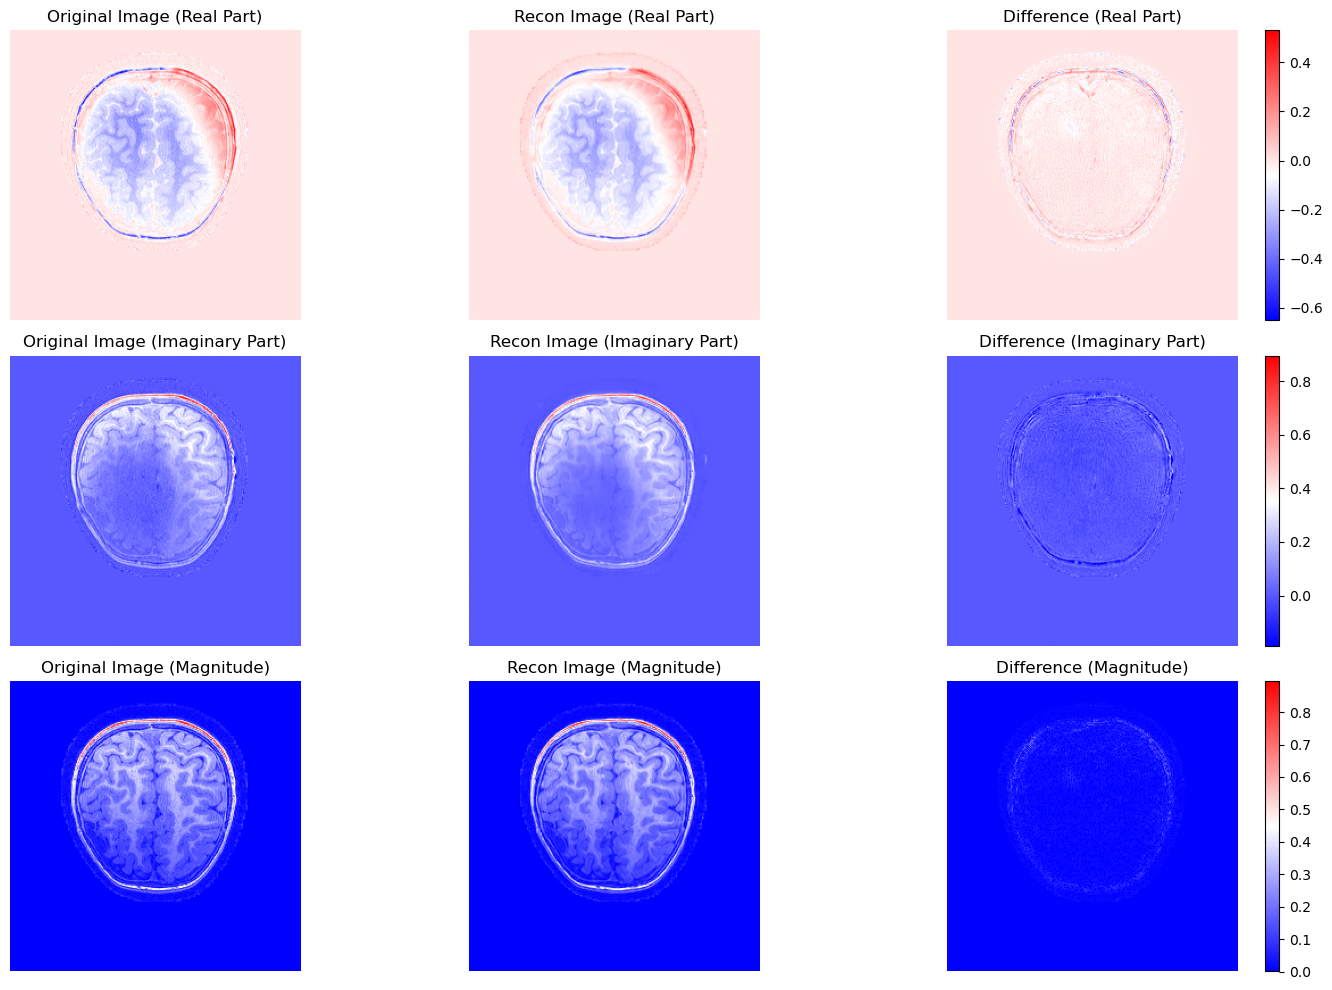

In [8]:
# compare image and reconstruction with diff plot
image = to_image_complex(sample["img"])
reconstruction = to_image_complex(reconstructions[0])
# match amplitude and phase
m = np.vdot(image, reconstruction) / np.vdot(reconstruction, reconstruction)
reconstruction = reconstruction * m

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
vmax = max(np.max(image.real), np.max(reconstruction.real))
vmin = min(np.min(image.real), np.min(reconstruction.real))
im = axs[0, 0].imshow(image.real, cmap="bwr", vmin=vmin, vmax=vmax)
axs[0, 0].set_title("Original Image (Real Part)")
axs[0, 0].axis("off")
axs[0, 1].imshow(reconstruction.real, cmap="bwr", vmin=vmin, vmax=vmax)
axs[0, 1].set_title("Recon Image (Real Part)")
axs[0, 1].axis("off")
im = axs[0, 2].imshow(
    image.real - reconstruction.real, cmap="bwr", vmin=vmin, vmax=vmax
)
axs[0, 2].set_title("Difference (Real Part)")
axs[0, 2].axis("off")
cbar = fig.colorbar(im, ax=axs[0, 2])

vmax = max(np.max(image.imag), np.max(reconstruction.imag))
vmin = min(np.min(image.imag), np.min(reconstruction.imag))
axs[1, 0].imshow(image.imag, cmap="bwr", vmin=vmin, vmax=vmax)
axs[1, 0].set_title("Original Image (Imaginary Part)")
axs[1, 0].axis("off")
axs[1, 1].imshow(reconstruction.imag, cmap="bwr", vmin=vmin, vmax=vmax)
axs[1, 1].set_title("Recon Image (Imaginary Part)")
axs[1, 1].axis("off")
im = axs[1, 2].imshow(
    image.imag - reconstruction.imag, cmap="bwr", vmin=vmin, vmax=vmax
)
axs[1, 2].set_title("Difference (Imaginary Part)")
axs[1, 2].axis("off")
cbar = fig.colorbar(im, ax=axs[1, 2])
vmax = max(np.max(np.abs(image)), np.max(np.abs(reconstruction)))
vmin = min(np.min(np.abs(image)), np.min(np.abs(reconstruction)))
axs[2, 0].imshow(np.abs(image), cmap="bwr", vmin=vmin, vmax=vmax)
axs[2, 0].set_title("Original Image (Magnitude)")
axs[2, 0].axis("off")
axs[2, 1].imshow(np.abs(reconstruction), cmap="bwr", vmin=vmin, vmax=vmax)
axs[2, 1].set_title("Recon Image (Magnitude)")
axs[2, 1].axis("off")
im = axs[2, 2].imshow(
    np.abs(np.abs(image) - np.abs(reconstruction)), cmap="bwr", vmin=vmin, vmax=vmax
)
axs[2, 2].set_title("Difference (Magnitude)")
axs[2, 2].axis("off")
cbar = fig.colorbar(im, ax=axs[2, 2])
plt.tight_layout()
plt.show()

In [9]:
with torch.no_grad():
    sample = bruno_dicom[1553]
    reconstructions, posterior, latent = model(
        sample["img"].unsqueeze(0).to(accelerator.device)
    )

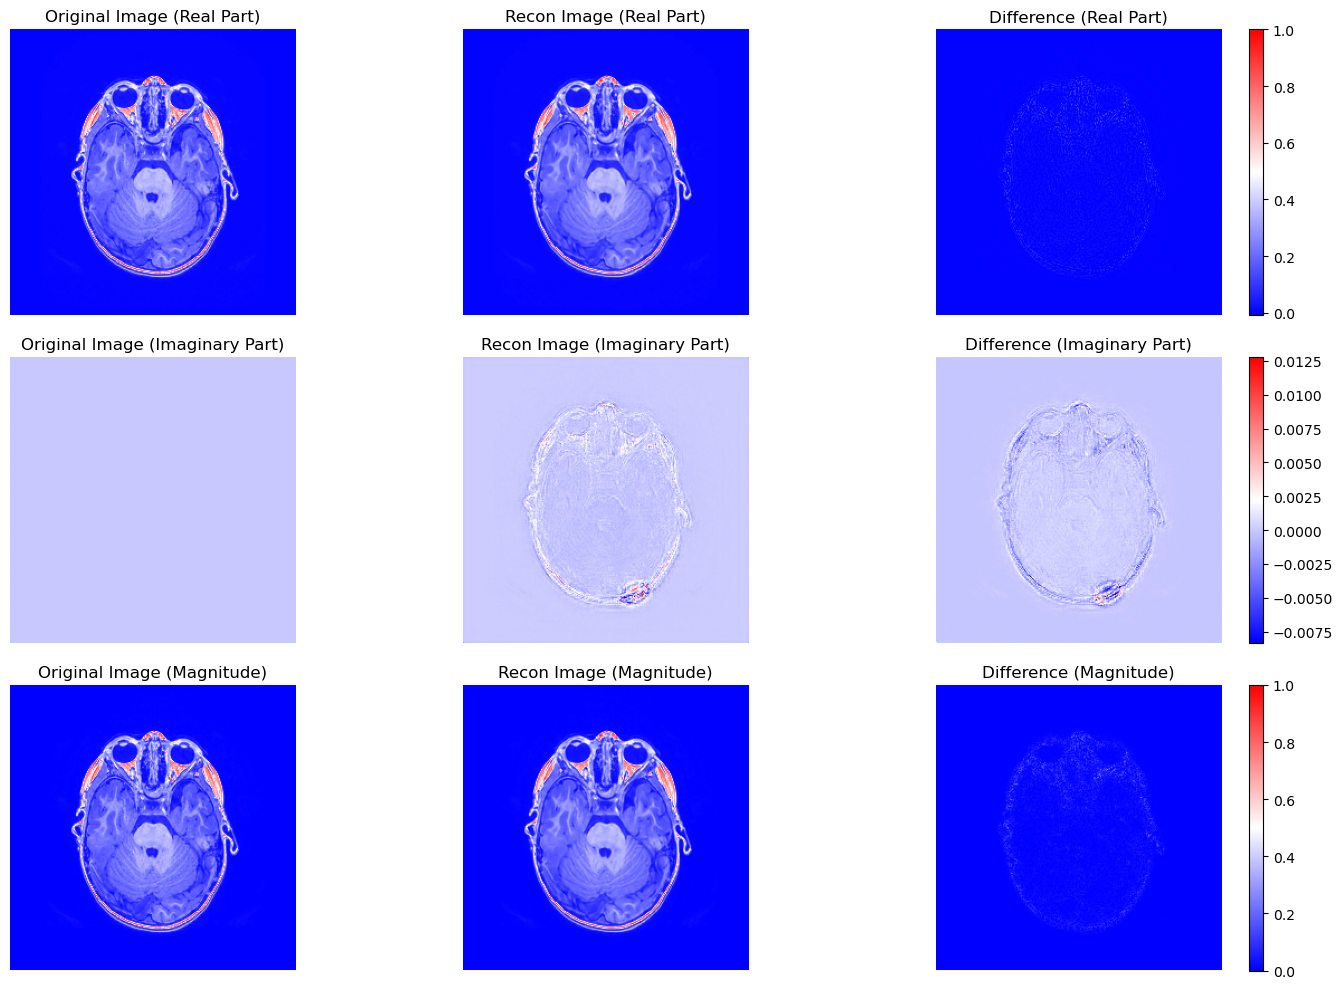

In [10]:
# compare image and reconstruction with diff plot
image = to_image_complex(sample["img"])
reconstruction = to_image_complex(reconstructions[0])
# match amplitude and phase
m = np.vdot(image, reconstruction) / np.vdot(reconstruction, reconstruction)
reconstruction = reconstruction * m

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
vmax = max(np.max(image.real), np.max(reconstruction.real))
vmin = min(np.min(image.real), np.min(reconstruction.real))
im = axs[0, 0].imshow(image.real, cmap="bwr", vmin=vmin, vmax=vmax)
axs[0, 0].set_title("Original Image (Real Part)")
axs[0, 0].axis("off")
axs[0, 1].imshow(reconstruction.real, cmap="bwr", vmin=vmin, vmax=vmax)
axs[0, 1].set_title("Recon Image (Real Part)")
axs[0, 1].axis("off")
im = axs[0, 2].imshow(
    image.real - reconstruction.real, cmap="bwr", vmin=vmin, vmax=vmax
)
axs[0, 2].set_title("Difference (Real Part)")
axs[0, 2].axis("off")
cbar = fig.colorbar(im, ax=axs[0, 2])

vmax = max(np.max(image.imag), np.max(reconstruction.imag))
vmin = min(np.min(image.imag), np.min(reconstruction.imag))
axs[1, 0].imshow(image.imag, cmap="bwr", vmin=vmin, vmax=vmax)
axs[1, 0].set_title("Original Image (Imaginary Part)")
axs[1, 0].axis("off")
axs[1, 1].imshow(reconstruction.imag, cmap="bwr", vmin=vmin, vmax=vmax)
axs[1, 1].set_title("Recon Image (Imaginary Part)")
axs[1, 1].axis("off")
im = axs[1, 2].imshow(
    image.imag - reconstruction.imag, cmap="bwr", vmin=vmin, vmax=vmax
)
axs[1, 2].set_title("Difference (Imaginary Part)")
axs[1, 2].axis("off")
cbar = fig.colorbar(im, ax=axs[1, 2])
vmax = max(np.max(np.abs(image)), np.max(np.abs(reconstruction)))
vmin = min(np.min(np.abs(image)), np.min(np.abs(reconstruction)))
axs[2, 0].imshow(np.abs(image), cmap="bwr", vmin=vmin, vmax=vmax)
axs[2, 0].set_title("Original Image (Magnitude)")
axs[2, 0].axis("off")
axs[2, 1].imshow(np.abs(reconstruction), cmap="bwr", vmin=vmin, vmax=vmax)
axs[2, 1].set_title("Recon Image (Magnitude)")
axs[2, 1].axis("off")
im = axs[2, 2].imshow(
    np.abs(np.abs(image) - np.abs(reconstruction)), cmap="bwr", vmin=vmin, vmax=vmax
)
axs[2, 2].set_title("Difference (Magnitude)")
axs[2, 2].axis("off")
cbar = fig.colorbar(im, ax=axs[2, 2])
plt.tight_layout()
plt.show()